<a href="https://colab.research.google.com/github/at9725/random-code/blob/main/portfolio_optimization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize


In [ ]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [ ]:
end_date = datetime.today()


In [ ]:
start_date = end_date - timedelta(days = 10 * 365)
print(start_date)

2015-01-05 02:17:20.873527


In [ ]:
adj_close_df = pd.DataFrame()

In [ ]:
for ticker in tickers:
  data = yf.download(ticker, start = start_date, end = end_date)
  adj_close_df[ticker] = data['Adj Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2015-01-05  169.475891  62.959358  115.800003   93.867714   87.635689
2015-01-06  167.879578  63.141655  117.120003   92.609116   86.777016
2015-01-07  169.971695  63.179623  116.430000   93.802948   87.812485
2015-01-08  172.987762  63.080868  115.940002   95.598297   89.361450
2015-01-09  171.601471  63.187233  117.260002   94.969009   88.620674
...                ...        ...         ...         ...         ...
2024-12-24  601.299988  71.849998  241.440002  529.960022  297.119995
2024-12-26  601.340027  71.900002  243.070007  529.599976  297.290009
2024-12-27  595.010010  71.750000  241.399994  522.559998  294.070007
2024-12-30  588.219971  72.029999  240.630005  515.609985  290.820007
2024-12-31  586.080017  71.910004  242.130005  511.230011  289.809998

[2515 rows x 5 columns]


In [ ]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [ ]:
log_returns = log_returns.dropna()

In [ ]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.031233  0.001065  0.001205  0.035937  0.031763
BND  0.001065  0.002977  0.002798  0.001384  0.001156
GLD  0.001205  0.002798  0.019939  0.001773  0.001312
QQQ  0.035937  0.001384  0.001773  0.047856  0.036483
VTI  0.031763  0.001156  0.001312  0.036483  0.032567


In [ ]:
def standard_deviation(weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

In [ ]:
def expected_return(weights, log_returns):
  return np.sum(log_returns.mean() * weights) * 252


In [ ]:
def sharpe_ratio(weights, log_returns, cov_matrix,risk_free_return):
  return expected_return(weights, log_returns) - risk_free_return / standard_deviation(weights, cov_matrix)
#

In [ ]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)
#

In [ ]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0,0.5) for _ in range(len(tickers))]

In [ ]:
initial_weights = np.array([1/len(tickers)]* len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [ ]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate),
                             method = 'SLSQP', bounds = bounds, constraints = constraints)

In [ ]:
optimal_weights = optimized_results.x

In [ ]:
print("Optimal_weights: ")

for ticker, weight in zip(tickers, optimal_weights):
  print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)


print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal_weights: 
SPY: 0.2474
BND: 0.0000
GLD: 0.0000
QQQ: 0.5000
VTI: 0.2526

Expected Annual Return: 0.1460
Expected Volatility: 0.1950
Sharpe Ratio: -0.0776


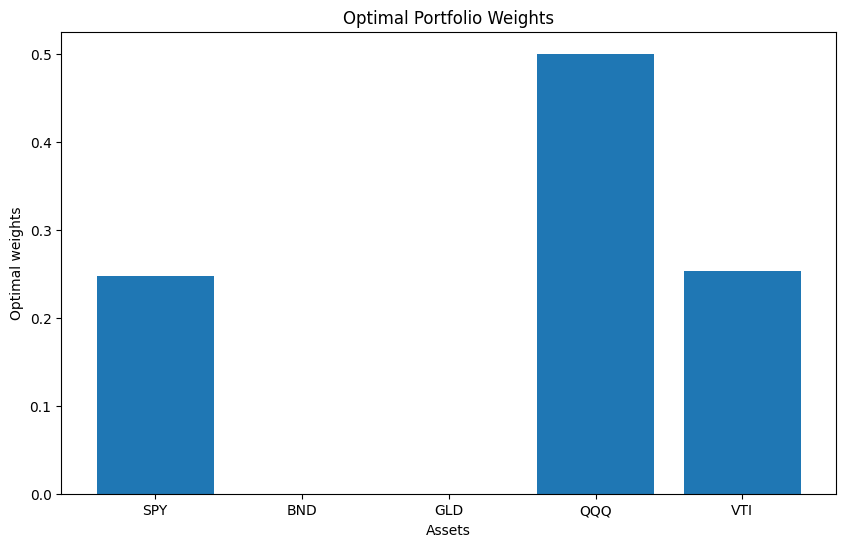

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

plt.xlabel("Assets")
plt.ylabel("Optimal weights")
plt.title("Optimal Portfolio Weights")

plt.show()